In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, circuit, extensions
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import reduce
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from datetime import datetime
from qiskit.aqua.components.optimizers import COBYLA, ADAM, AQGD, NFT

/home/mauk/.local/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [2]:
def normalize(l):
    normalization_factor = math.sqrt(sum([i ** 2 for i in l]))
    return [i / normalization_factor for i in l]

def init_gate(init_states, label=None, size=None):
    if not size:
        size = math.ceil(math.log2(len(init_states)))
    state_vector = normalize(init_states) + [0] * ((2 ** size) - len(init_states))
    #I know this is way ugly, but it's the easiest way to actualy turn initialize() into a gate
    return extensions.Initialize(state_vector).gates_to_uncompute().inverse().to_gate(label=label if label else None)

In [3]:
def x_indices(i, bits):
    indices = []
    for j in range(bits):
        bit = (i >> j) & 1
        if not bit:
            indices.append(j)
    return indices

In [4]:
def construct_oracle(data, labels):
    # gate = init_gate([0,2,10], "psi_0")
    data_bits = math.ceil(math.log2(data.shape[1]))
    counting_bits = math.ceil(math.log2(data.shape[0]))
#     print(len(data), data.shape[0])
    q = QuantumRegister(data_bits + counting_bits + 1)
    qc = QuantumCircuit(q)

#     data = [[x,x*2,x**2] for x in range(1, 16)]
    qc.h(q[data_bits + 1:])
    for i in range(len(data)):
        x_i = [data_bits + 1 + x_i for x_i in x_indices(i,counting_bits)]
        if len(x_i) > 0:
            qc.x(x_i)
        gate = init_gate(data[i], f"psi_{i}", data_bits).control(counting_bits)
        qc.append(gate, q[data_bits + 1:] + q[:data_bits])
        if labels[i] == 1:
            x_gate = circuit.library.XGate().control(counting_bits)
            qc.append(x_gate, q[data_bits + 1:] + [q[data_bits]])

        if len(x_i) > 0:
            qc.x(x_i)
    return qc, data_bits, counting_bits

In [5]:
def destructive_swap(n):
    q = QuantumRegister(n * 2)
    circuit = QuantumCircuit(q)
    
    for i in range(n):
        circuit.cx(i, n+i)
        circuit.h(i)
#     print(circuit)
    return circuit.to_gate(label="destructive_swap")


In [6]:
def interpret_des_swap(counts):
    successes = 0
    for k in counts:
        #success if and of measurement has even parity, that's what the paper said
        success = reduce(lambda b, p: (p == ('1', '1')) ^ b , zip(list(k[:len(k)//2]), list(k[len(k)//2:])), True)
#         print(k, success)
#         success = k.count('1') % 2 == 0
        if success:
            successes += counts[k]
    if sum(counts.values()) == 0:
        return 0
    return  2 * (successes / sum(counts.values())) - 1

In [7]:
def construct_classifier(data, labels):
    input_size = math.ceil(math.log2(data.shape[1]))
    oracle, data_bits, counting_bits = construct_oracle(data, labels)
#     print(oracle)
    oracle = oracle.to_gate(label="oracle")
    q = QuantumRegister(input_size + data_bits + counting_bits + 1)
    c = ClassicalRegister(input_size * 2 + 1)
    qc = QuantumCircuit(q, c)
    
    qc.append(oracle, q[input_size:])
#     print(input_size)
    qc.append(destructive_swap(input_size), q[:input_size] + q[input_size:input_size+input_size])
    for i in range(input_size * 2 + 1):
        qc.measure(i,i)
    return qc


In [8]:
df = pd.read_csv("bezdekIris.data", header=None)

In [9]:
df[4] = [0 if p == "Iris-setosa" else 1 if p == "Iris-virginica" else 2 for p in df[4]]
df = df[df[4] != 2]

In [35]:
# TODO: Normalize data?

train, test = train_test_split(df, test_size=0.36)
data = train[[0,1]].to_numpy()
labels = train[4].to_numpy()

n_data_points = 64

n_label0s = n_data_points / 2
n_label1s = n_data_points / 2

label0s = []
label1s = []

for i in range(len(labels)):
    if labels[i] == 0 and n_label0s > 0:
        n_label0s -= 1
        label0s.append(i)
        
    if labels[i] == 1 and n_label1s > 0:
        n_label1s -= 1
        label1s.append(i)
        
    if n_label0s < 1 and n_label1s < 1:
        break

idx = label0s + label1s
        
data = data[idx]
labels = labels[idx]

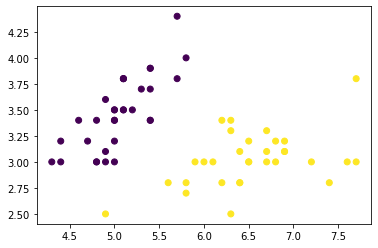

In [36]:
plt.scatter(x=data[:, 0], y=data[:, 1], c=labels)
plt.show()

/home/mauk/.local/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


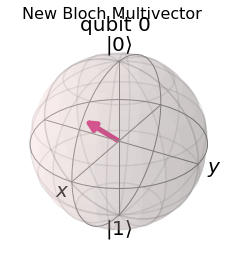

In [12]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

inp_gate = init_gate([6.5, 3], label="input", size=1)

qc.append(inp_gate, q[0:1])

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state, title="New Bloch Multivector", reverse_bits=False)

/home/mauk/.local/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


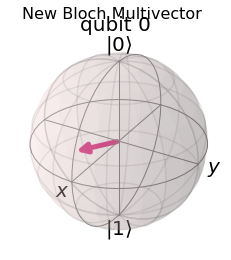

In [13]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

inp_gate = init_gate([5, 3.5], label="input", size=1)

qc.append(inp_gate, q[0:1])

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state, title="New Bloch Multivector", reverse_bits=False)

In [14]:
# data = np.ones((20,4))
# data = np.array([np.array([1,2,0,4]) for i in range(20)])


qc_classifier = construct_classifier(data, labels)


In [15]:
def classify(inp):
    num_qubits = qc_classifier.num_qubits

    data_size = math.ceil(math.log2(data.shape[1]))

    num_cbits = data_size * 2 + 1


    q = QuantumRegister(num_qubits)
    c = ClassicalRegister(num_cbits)
    qc = QuantumCircuit(q, c)

    # inp_gate = init_gate([1,2,0,4])
    inp_gate = init_gate(inp, label="input", size=data_size)


    qc.append(inp_gate, q[0:1])
    qc = qc.compose(qc_classifier)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=500)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

In [16]:
# labels = [0,1]
# correct = 0
# count = 0
# for index, row in test.iterrows():
#     label = row[4]
#     results = classify(row[[0,1]].tolist())
#     cor = False
#     if results[0] > results[1] and label == labels[0]:
#         correct += 1
#         cor = True
#     elif results[0] < results[1] and label == labels[1]:
#         correct += 1
#         cor = True
#     count += 1
#     print(f"features:({row[0]}, {row[1]}), label:{label}, result:{labels[0]}:{results[0]}, {labels[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

# print(correct / len(test))


In [17]:
num_qubits = qc_classifier.num_qubits

data_size = math.ceil(math.log2(data.shape[1]))

num_cbits = data_size * 2 + 1

q = QuantumRegister(num_qubits)
c = ClassicalRegister(num_cbits)
qc = QuantumCircuit(q, c)

# inp_gate = init_gate([1,2,0,4])
inp_gate = init_gate([1,2], label="input", size=data_size)

qc.append(inp_gate, q[0:1])
qc = qc.compose(qc_classifier)
print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=2000)
result = job.result()

# print(result.get_counts())
counts = result.get_counts()

counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

print(counts)
print(interpret_des_swap(counts_0))
print(interpret_des_swap(counts_1))

        ┌───────┐ ┌───────────────────┐┌─┐   
q13_0: ─┤ input ├─┤0                  ├┤M├───
       ┌┴───────┴┐│  destructive_swap │└╥┘┌─┐
q13_1: ┤0        ├┤1                  ├─╫─┤M├
       │         │└────────┬─┬────────┘ ║ └╥┘
q13_2: ┤1 oracle ├─────────┤M├──────────╫──╫─
       │         │         └╥┘          ║  ║ 
q13_3: ┤2        ├──────────╫───────────╫──╫─
       └─────────┘          ║           ║  ║ 
 c3: 3/═════════════════════╩═══════════╩══╩═
                            2           0  1 
{'001': 5, '101': 6, '100': 251, '110': 509, '010': 474, '000': 371, '011': 134, '111': 250}
0.7276422764227641
0.5078740157480315


In [18]:
# n_features gets boiled down to amount of qubits necessary for it to work TODO: Change n_labels to do the same
def build_variational_circuit(depth, n_features, n_labels, params=None, measurement=False):
    # TODO: Add y and z rotations
    n_qubits = math.ceil(math.log2(n_features)) + n_labels
    
    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum
    
    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_rot_qubits_per_layer + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)
    
#     print(params)
    
    if params is None:
        params = np.random.rand(depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
#     print(params)
    
#     print(len(params))
    
    q = QuantumRegister(n_qubits)
    if measurement:
        c = ClassicalRegister(n_qubits)
        qc = QuantumCircuit(q, c)
    else:
        qc = QuantumCircuit(q)
        
    
    # Dynamically add rx rotation and rxx entanglement gates
    for i in range(depth):
        for j in range(n_qubits):
#             print(i * depth, j)
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            qc.rx(params[i * n_qubits_per_layer + j*2], j)
            qc.rz(params[i * n_qubits_per_layer + j*2 + 1], j)
        next_param = 0
        for j in range(n_qubits):
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            for k in range(n_qubits):
                if j == k or j < k:
                    continue
#                 print(i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param)
#                 print(i * n_rot_qubits_per_layer + j + next_param + n_rot_qubits_per_layer)
                qc.rxx(params[i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param], j, k)
                next_param += 1
        
        if measurement:
            qc.barrier()
    
    if measurement:
        for i in range(n_qubits):
            qc.measure(i, i)
            
    return qc
      
build_variational_circuit(3, 8, 1, measurement=True).draw()

┌─────────────┐ ┌────────────┐┌──────────────┐┌──────────────┐»
q46_0: ┤ Rx(0.59705) ├─┤ Rz(2.1105) ├┤1             ├┤1             ├»
       └┬───────────┬┘┌┴────────────┤│  Rxx(2.5239) ││              │»
q46_1: ─┤ Rx(2.957) ├─┤ Rz(0.57967) ├┤0             ├┤  Rxx(0.9903) ├»
       ┌┴───────────┴┐├─────────────┤└──────────────┘│              │»
q46_2: ┤ Rx(0.98167) ├┤ Rz(0.64902) ├────────────────┤0             ├»
       └┬────────────┤├─────────────┤                └──────────────┘»
q46_3: ─┤ Rx(0.8295) ├┤ Rz(0.33415) ├────────────────────────────────»
        └────────────┘└─────────────┘                                »
 c4: 4/══════════════════════════════════════════════════════════════»
                                                                     »
«                       ┌──────────────┐                                 ░ »
«q46_0: ────────────────┤1             ├─────────────────────────────────░─»
«       ┌──────────────┐│              │┌──────────────┐                 ░ »
«q46_1: ┤1             ├┤              ├┤1             ├─────────────────░─»
«       │  Rxx(1.3682) ││  Rxx(1.0969) ││              │┌──────────────┐ ░ »
«q46_2: ┤0             ├┤              ├┤  Rxx(2.9058) ├┤1             ├─░─»
«       └──────────────┘│              ││              ││  Rxx(1.0691) │ ░ »
«q46_3: ────────────────┤0             ├┤0             ├┤0             ├─░─»
«                       └──────────────┘└──────────────┘└──────────────┘ ░ »
« c4: 4/═══════════════════════════════════════════════════════════════════»
«                                                                          »
«       ┌────────────┐ ┌────────────┐┌──────────────┐┌──────────────┐»
«q46_0: ┤ Rx(1.0834) ├─┤ Rz(2.5532) ├┤1             ├┤1             ├»
«       ├────────────┤ ├────────────┤│  Rxx(1.3945) ││              │»
«q46_1: ┤ Rx(3.1226) ├─┤ Rz(1.8955) ├┤0             ├┤  Rxx(2.4036) ├»
«       ├────────────┤┌┴────────────┤└──────────────┘│              │»
«q46_2: ┤ Rx(1.1357) ├┤ Rz(0.22901) ├────────────────┤0             ├»
«       ├───────────┬┘└┬────────────┤                └──────────────┘»
«q46_3: ┤ Rx(2.783) ├──┤ Rz(2.9018) ├────────────────────────────────»
«       └───────────┘  └────────────┘                                »
« c4: 4/═════════════════════════════════════════════════════════════»
«                                                                    »
«                        ┌──────────────┐                                 ░ »
«q46_0: ─────────────────┤1             ├─────────────────────────────────░─»
«       ┌───────────────┐│              │┌──────────────┐                 ░ »
«q46_1: ┤1              ├┤              ├┤1             ├─────────────────░─»
«       │  Rxx(0.28872) ││  Rxx(1.1873) ││              │┌──────────────┐ ░ »
«q46_2: ┤0              ├┤              ├┤  Rxx(1.1716) ├┤1             ├─░─»
«       └───────────────┘│              ││              ││  Rxx(1.6844) │ ░ »
«q46_3: ─────────────────┤0             ├┤0             ├┤0             ├─░─»
«                        └──────────────┘└──────────────┘└──────────────┘ ░ »
« c4: 4/════════════════════════════════════════════════════════════════════»
«                                                                           »
«        ┌────────────┐┌────────────┐┌──────────────┐┌──────────────┐»
«q46_0: ─┤ Rx(2.8326) ├┤ Rz(2.0809) ├┤1             ├┤1             ├»
«        ├────────────┤├────────────┤│  Rxx(1.5723) ││              │»
«q46_1: ─┤ Rx(1.2808) ├┤ Rz(1.2958) ├┤0             ├┤  Rxx(2.6409) ├»
«        ├────────────┤├────────────┤└──────────────┘│              │»
«q46_2: ─┤ Rx(2.4056) ├┤ Rz(2.1863) ├────────────────┤0             ├»
«       ┌┴────────────┤├────────────┤                └──────────────┘»
«q46_3: ┤ Rx(0.71781) ├┤ Rz(1.4843) ├────────────────────────────────»
«       └─────────────┘└────────────┘                                »
« c4: 4/═════════════════════════════════════════════════════════════»
«                             

In [33]:
def construct_generator_classifier(depth, n_features, n_labels, inp, params):
#     print(data.shape)
    input_size = math.ceil(math.log2(data.shape[1]))
#     oracle, data_bits, counting_bits = construct_oracle(data, labels)
    variational_oracle = build_variational_circuit(depth, n_features, n_labels, params)
    variational_oracle_gate = variational_oracle.to_gate(label="variational_oracle")
    q = QuantumRegister(input_size + variational_oracle.num_qubits + 1)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q, c)
#     print(input_size)

    inp_gate = init_gate(inp, label="input", size=input_size)
    
    swap_test_ancilla = q[0:1]
    inp_qubits = q[1:input_size + 1]
    oracle_data_qubits = q[input_size + 1:input_size * 2 + 1]
    label_qubit = q[input_size * 2 + 1:input_size * 2 + 2]
    extra_oracle_qubits = q[input_size * 2 + 2:]
    
#     print("swap_test_ancilla", len(swap_test_ancilla))
#     print("inp_qubits", len(inp_qubits))
#     print("oracle_data_qubits", len(oracle_data_qubits))
#     print("label_qubit", len(label_qubit))
#     print(variational_oracle)

    qc.append(inp_gate, inp_qubits)
    qc.append(variational_oracle_gate, oracle_data_qubits + label_qubit + extra_oracle_qubits)
    qc.append(swap(input_size), swap_test_ancilla + inp_qubits + oracle_data_qubits)
    qc.measure(swap_test_ancilla, 0)
    qc.measure(label_qubit, 1)

    return qc

# params = [1, 1, 1, 1, 1, 1, 1, 1, 1]
# construct_generator_classifier([1, 2], params).draw()

In [20]:
def swap(n):
    q = QuantumRegister(n * 2 + 1)
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    
    for i in range(0, n):
        circuit.cswap(0, 1 + i, 1 + n+i)
    circuit.h(q[0])
    return circuit.to_gate(label="swap")

In [21]:
def build_gan_stack(depth, n_features, n_labels, params=None):
    oracle, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
    generator = build_variational_circuit(depth, n_features, n_labels, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = n_counting_qubits + n_data_qubits + generator.num_qubits + 2
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
    generator_output_qubits = q[1:1 + n_data_qubits + 1]
    oracle_qubits = q[generator.num_qubits + 1:]
    oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + 1 + n_data_qubits]
    oracle_label_qubits = q[generator.num_qubits + 1 + n_data_qubits:generator.num_qubits + 1 + n_data_qubits + 1]

    oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    
    swap_test_gate = swap(n_data_qubits + 1)
    swap_test_qubits = swap_ancilla + generator_output_qubits + oracle_output_qubits + oracle_label_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

build_gan_stack(8, 8, 1).draw()

┌───────┐┌─┐
q53_0: ──────────────┤0      ├┤M├
       ┌────────────┐│       │└╥┘
q53_1: ┤0           ├┤1      ├─╫─
       │            ││       │ ║ 
q53_2: ┤1           ├┤2      ├─╫─
       │  generator ││       │ ║ 
q53_3: ┤2           ├┤  swap ├─╫─
       │            ││       │ ║ 
q53_4: ┤3           ├┤       ├─╫─
       └┬─────────┬─┘│       │ ║ 
q53_5: ─┤0        ├──┤3      ├─╫─
        │         │  │       │ ║ 
q53_6: ─┤1 oracle ├──┤4      ├─╫─
        │         │  └───────┘ ║ 
q53_7: ─┤2        ├────────────╫─
        └─────────┘            ║ 
 c5: 1/════════════════════════╩═
                               0

In [22]:
gan_stack_qc = build_gan_stack(3, 8, 1)

In [23]:
def get_generator_similarity(gan_stack_qc):
    start = datetime.now()
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=gan_stack_qc, shots=200)
    result = job.result()

    counts = result.get_counts()
    return counts
#     print(counts)
#     print(datetime.now() - start)

In [24]:
def classify_variationally(depth, n_features, n_labels, params, data_point):
    variational_classifier = construct_generator_classifier(depth, n_features, n_labels, data_point, params)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=variational_classifier, shots=1500)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

# data_point = [5, 3.5]
# params = [1, 1, 1, 1, 1, 1, 1, 1, 1]
# classify_variationally(params, data_point)

In [25]:
label_names = [0,1]
params = None# [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
correct = 0
count = 0
for index, row in test.iterrows():
    label = row[4]
    results = classify_variationally(8, 2, 1, params, row[[0,1]].tolist())
    cor = False
    if results[0] > results[1] and label == label_names[0]:
        correct += 1
        cor = True
    elif results[0] < results[1] and label == label_names[1]:
        correct += 1
        cor = True
    count += 1
    print(f"features:({row[0]}, {row[1]}), label:{label}, result:{label_names[0]}:{results[0]}, {label_names[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

print(correct / len(test))

features:(5.0, 3.4), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.4, 3.2), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.9, 3.1), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.9, 3.0), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.2, 2.8), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.7, 3.1), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.6, 3.2), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.4, 3.9), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.8, 3.0), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.7, 3.8), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.9, 3.1), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.3, 2.9), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.2, 3.6), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0

Initial parameters: [2.43913602 0.54055193 1.06164177 1.28664329 0.7752141  1.88026993
 0.36025346 0.20606574 1.22702336 0.85304251 2.89326677 1.62041741
 0.0930799  1.02078414 0.58191175 2.61461584 1.28484451 0.6980421
 0.40714099 2.3108267  1.76809808 2.94122224 1.52646467 0.65641311
 1.28447122 0.46255587 0.63811851 1.53050358 2.25650375 0.13729123
 2.36414108 0.14819424 0.15533184 0.74830863 0.18341364 2.70313399
 2.25994242 1.2660087  0.9502523  0.61402168 1.0068747  2.39890006
 2.47479057 1.14149873 0.68147847 1.33789608 2.5549035  0.09725449
 2.62074197 1.14846035 2.4695586  0.01658579 1.46002731 2.32393345
 2.21633415 0.78148007 3.0117504  1.35996563 1.54272748 3.02183723
 1.58324015 2.52693081 1.15969866 2.78963618 2.68591047 2.40413074
 0.94763688 0.37798285 2.51337642 0.8606452  2.36993731 3.1329247
 0.32038233 1.82746095 1.92627803 1.94379598 2.67518082 0.23427955
 2.4404991  1.04413839 2.71376858 1.84237788 1.28881807 1.1504894
 1.02229886 2.05074685 1.32850269 0.25627834 

/home/mauk/.local/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',


3 opt -0.276 cur -0.276
4 opt -0.276 cur -0.15599999999999992
5 opt -0.276 cur -0.19599999999999995
6 opt -0.276 cur -0.236
7 opt -0.276 cur -0.22399999999999998
8 opt -0.3720000000000001 cur -0.3720000000000001
9 opt -0.3720000000000001 cur -0.29200000000000004
10 opt -0.4119999999999999 cur -0.4119999999999999
11 opt -0.45199999999999996 cur -0.45199999999999996
12 opt -0.45199999999999996 cur -0.30000000000000004
13 opt -0.45199999999999996 cur -0.3839999999999999
14 opt -0.45199999999999996 cur -0.3680000000000001
15 opt -0.45199999999999996 cur -0.3959999999999999
16 opt -0.45199999999999996 cur -0.3959999999999999
17 opt -0.45199999999999996 cur -0.3999999999999999
18 opt -0.45199999999999996 cur -0.4159999999999999
19 opt -0.45199999999999996 cur -0.3919999999999999
20 opt -0.45199999999999996 cur -0.43999999999999995
21 opt -0.45199999999999996 cur -0.3959999999999999
22 opt -0.45199999999999996 cur -0.3839999999999999
23 opt -0.45199999999999996 cur -0.3600000000000001
24 opt 

187 opt -0.5760000000000001 cur -0.44399999999999995
188 opt -0.5760000000000001 cur -0.536
189 opt -0.5760000000000001 cur -0.42799999999999994
190 opt -0.5760000000000001 cur -0.43599999999999994
191 opt -0.5760000000000001 cur -0.472
192 opt -0.5760000000000001 cur -0.472
193 opt -0.5760000000000001 cur -0.504
194 opt -0.5760000000000001 cur -0.512
195 opt -0.5760000000000001 cur -0.504
196 opt -0.5760000000000001 cur -0.44399999999999995
197 opt -0.5760000000000001 cur -0.46399999999999997
198 opt -0.5760000000000001 cur -0.3959999999999999
199 opt -0.5760000000000001 cur -0.512
200 opt -0.5760000000000001 cur -0.43199999999999994
201 opt -0.5760000000000001 cur -0.476
202 opt -0.5760000000000001 cur -0.504
203 opt -0.5760000000000001 cur -0.43599999999999994
204 opt -0.5760000000000001 cur -0.46399999999999997
205 opt -0.5760000000000001 cur -0.46799999999999997
206 opt -0.5760000000000001 cur -0.45999999999999996
207 opt -0.5760000000000001 cur -0.41999999999999993
208 opt -0.576

367 opt -0.5760000000000001 cur -0.48
368 opt -0.5760000000000001 cur -0.3440000000000001
369 opt -0.5760000000000001 cur -0.508
370 opt -0.5760000000000001 cur -0.46399999999999997
371 opt -0.5760000000000001 cur -0.536
372 opt -0.5760000000000001 cur -0.484
373 opt -0.5760000000000001 cur -0.532
374 opt -0.5760000000000001 cur -0.528
375 opt -0.5760000000000001 cur -0.556
376 opt -0.5760000000000001 cur -0.44399999999999995
377 opt -0.5760000000000001 cur -0.4079999999999999
378 opt -0.5760000000000001 cur -0.43599999999999994
379 opt -0.5760000000000001 cur -0.43199999999999994
380 opt -0.5760000000000001 cur -0.42799999999999994
381 opt -0.5760000000000001 cur -0.45999999999999996
382 opt -0.5760000000000001 cur -0.45199999999999996
383 opt -0.5760000000000001 cur -0.48
384 opt -0.5760000000000001 cur -0.4159999999999999
385 opt -0.5760000000000001 cur -0.476
386 opt -0.5760000000000001 cur -0.3999999999999999
387 opt -0.5760000000000001 cur -0.48
388 opt -0.5760000000000001 cur -0

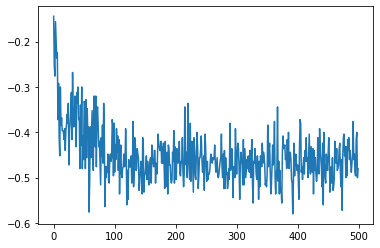

Supposed optimal parameters: [3.43923459 1.54057222 1.06165607 1.28663929 0.77520783 1.88021616
 1.36024941 0.20609196 2.22700328 1.85306729 2.89325948 1.62044664
 0.09301383 1.02073805 0.58188114 2.6146011  1.2848747  0.69807906
 0.40712945 2.31083169 1.76809675 2.94126353 1.52647479 0.65640254
 2.28448763 0.46253945 0.63815417 1.53051727 2.25652873 0.13727709
 2.36419044 0.14824535 0.15538644 0.74830861 0.1833788  2.70310451
 2.25988918 1.26593485 0.95027856 0.61403171 1.0069229  2.39888842
 3.47474898 1.14160244 0.68146969 1.33796335 2.55486931 0.09723527
 2.62071839 1.14850923 2.46958893 0.01649777 1.46007977 2.32394191
 2.21636488 0.7815385  3.01175559 2.35997262 1.54275881 3.02185878
 1.583271   2.52691454 1.15971139 2.78964426 2.68589603 2.40416437
 0.94770608 0.37796721 2.5142058  0.85873856 2.36993068 3.13294312
 0.32164574 1.8258989  1.92490348 1.94577178 2.67427509 0.23469063
 2.44053113 1.04412972 2.71375282 1.84236142 1.2888468  1.15058324
 1.02233613 2.05076872 1.32854067

In [26]:
# Define variational circuit_variables
circuit_depth = 10
n_features = 4
n_labels = 1

intermediate_results = []

global optimal_params
optimal_params = []
global optimal_cost
optimal_cost = 0
global i
i = 0

def objective_function(params):
    global i
    global optimal_cost
    global optimal_params
    
    i += 1
    
    # construct circuit with given params
    qc = build_gan_stack(circuit_depth, n_features, n_labels, params)
    
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=500)
    counts = job.result().get_counts()
    
    result = 2 * counts['0'] / sum(counts.values()) - 1
    
    result = -result
    
    intermediate_results.append(result)
    
    if result < optimal_cost:
        optimal_cost = result
        optimal_params = params
#         print(params)
        
    print(i, "opt", optimal_cost, "cur", result)
    
    return result
    
def generate_params(circuit_depth, n_features, n_labels):
    
    n_qubits = math.ceil(math.log2(n_features)) + n_labels

    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum

    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_rot_qubits_per_layer + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    generated_params = np.random.rand(circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
    return generated_params
    
init_params = generate_params(circuit_depth, n_features, n_labels)

print("Initial parameters:", init_params)
# objective_function(params)
    
optimizer = COBYLA(maxiter=500)

ret = optimizer.optimize(num_vars=len(init_params), objective_function=objective_function, initial_point=init_params)

# print(")

plt.plot(intermediate_results)
plt.show()

print("Supposed optimal parameters:", optimal_params)
print("Supposed optimal cost:", optimal_cost)


In [34]:
label_names = [0,1]

correct = 0
count = 0
for index, row in test.iterrows():
    label = row[4]
    results = classify_variationally(circuit_depth, 
                                     n_features,
                                     n_labels, 
                                     optimal_params, 
                                     row[[0,1]].tolist())
    cor = False
    if results[0] > results[1] and label == label_names[0]:
        correct += 1
        cor = True
    elif results[0] < results[1] and label == label_names[1]:
        correct += 1
        cor = True
    count += 1
    print(f"features:({row[0]}, {row[1]}), label:{label}, result:{label_names[0]}:{results[0]}, {label_names[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

print(correct / len(test))

features:(5.0, 3.4), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.4, 3.2), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.9, 3.1), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.9, 3.0), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.2, 2.8), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.7, 3.1), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.6, 3.2), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.4, 3.9), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.8, 3.0), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.7, 3.8), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.9, 3.1), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.3, 2.9), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.2, 3.6), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0